### Notebook to genereate plots of isentropic binned variables.

James Ruppert  
jruppert@ou.edu  
5/10/24

In [1]:
# NOTE: Using copied tracking from CTL for NCRF tests

import numpy as np
from matplotlib import rc
from matplotlib import colors, ticker
import matplotlib.pyplot as plt
from read_functions import *
from thermo_functions import *

### Main settings

In [2]:
storm = 'haiyan'
# storm = 'maria'

# Set to true to do sensitivty test comparisons
# Else: analysis of CTL only
do_tests=False
# do_tests=True

main = "/ourdisk/hpc/radclouds/auto_archive_notyet/tape_2copies/tc_ens/"
figdir = "/home/jamesrup/figures/tc/ens/"+storm+'/'
datdir2 = 'post/d02/'

pclass_names = ['all','noncloud','deepc','congest','shallowc','strat','anvil']
pclass_title=["All", "Non-raining", "Deep", "Cong", "Shallow", "Strat", "Anvil"]
npclass = len(pclass_names)

# Tests to read and compare
if storm == 'haiyan':
    if do_tests:
        tests = ['ctl','ncrf36h','STRATANVIL_OFF','STRAT_OFF','STRATANVIL_ON']#,'crfon60h']
        tests_str = ['CTL','NCRF','STRATANV\nOFF','STRAT\nOFF','STRATANV\nON']#,'CRFON']
        # tests = ['ctl','ncrf36h']#,'crfon60h']
        # tests_str = ['CTL','NCRF']#,'CRFON']
    else:
        tests = ['ctl']
        tests_str = ['CTL']
    # tests = ['crfon','ncrf']
elif storm == 'maria':
    # tests = ['ctl','ncrf36h']
    if do_tests:
        tests = ['ctl','ncrf36h','ncrf48h']
        tests_str = ['CTL','NCRF1','NCRF2']
    else:
        tests = ['ctl']
        tests_str = ['CTL']

time_neglect=12 # time steps from start to neglect

# Shift starting-read time step for CRFON comparison
t0_test=0
# if 'crfon' in tests[1]:
#     t0_test=24 # CRFON is restarted at t=24 in NCRF
    # memb0=5 # for CRFFON test

# Members
nmem = 10 # number of ensemble members (1-5 have NCRF)
enstag = str(nmem)

In [3]:
# Theta-e (equivalent potential temperature) bins
fmin=305; fmax=365 # K
nbins = 70
bins=np.linspace(fmin,fmax,num=nbins)

# Ensemble member info
memb0=1 # Starting member to read
memb_nums=np.arange(memb0,nmem+memb0,1)
memb_nums_str=memb_nums.astype(str)
nustr = np.char.zfill(memb_nums_str, 2)
memb_all=np.char.add('memb_',nustr)

# Get dimensions
datdir = main+storm+'/'+memb_all[0]+'/'+tests[0]+'/'+datdir2
nt_data, nz, nx1, nx2, pres = get_file_dims(datdir)
nt=nt_data-time_neglect

In [4]:
################################################
#### NetCDF variable metadata

def var_regrid_metadata(nt,nz,nbins):

    nbinsm1 = nbins-1

    var_names = [
        'bins',
        'pres',
        'theta_e_mn',
        'frequency',
        'tmpk',
        'qv',
        'rho',
        'h_diabatic',
        'lw',
        'lwc',
        'sw',
        'swc',
        'w',
    ]
    descriptions = [
        'equivalent potential temperature bins',
        'pressure',
        'mean equivalent potential temperature',
        'frequency',
        'temperature',
        'water vapor mixing ratio',
        'density',
        'H_DIABATIC',
        'LW heat tendency',
        'LW clear-sky heat tendency',
        'SW heat tendency',
        'SW clear-sky heat tendency',
        'vertical motion',
    ]
    units = [
        'K',
        'hPa',
        'K',
        'n-cells',
        'K',
        'kg/kg',
        'kg/m^3',
        'K/s',
        'K/s',
        'K/s',
        'K/s',
        'K/s',
        'm/s',
    ]
    dims_all = (nt,nz,nbinsm1)
    dim_names = ('nt','nz','nbinsm1')
    dims_set = [
        [('nbins',),(nbins,)],
        [('nz',),(nz,)],
        [('nt','nz'),(nt,nz)],
        [dim_names,dims_all],
        [dim_names,dims_all],
        [dim_names,dims_all],
        [dim_names,dims_all],
        [dim_names,dims_all],
        [dim_names,dims_all],
        [dim_names,dims_all],
        [dim_names,dims_all],
        [dim_names,dims_all],
        [dim_names,dims_all],
    ]

    len1=len(var_names); len2=len(descriptions); len3=len(units); len4=len(dims_set) #len4=len(dim_names)
    if (len1 != len2) or (len1 != len3) or (len1 != len4):
        raise ValueError("Variable info counts are off")

    return var_names, descriptions, units, dims_set

# Variable info
var_names, descriptions, units, dims_set = var_regrid_metadata(nt,nz,nbins)

### Main read loop

In [5]:
# Main read loops for 3D (dependent) variables

ntest=len(tests)

allvars = []
# (itest, imemb, ivariable(ndarray))

for itest in range(ntest):

    test_str=tests[itest]
    print('Running test: ',test_str)

    if test_str == 'ctl':
        t0=time_neglect
        t1=nt+t0
        if do_tests:
            t0=36
            t1=t0+49
    else:
        t0=0
        t1=49

    # Loop over ensemble members

    itest_ens = []
    for imemb in range(nmem):

        print('Running member: ',memb_all[imemb])
        datdir = main+storm+'/'+memb_all[imemb]+'/'+test_str+'/'+datdir2

        imemb_allclass = []
        for ipclass in range(npclass):

            pclass_tag = pclass_names[ipclass]
            isentrop_file = datdir+'binned_isentrop_'+pclass_tag+'.nc'
            ncfile = Dataset(isentrop_file)

            vars_ipclass = []
            for ivar in var_names:
                vars_ipclass.append(ncfile.variables[ivar][t0:t1,...])

            ncfile.close()
            
            imemb_allclass.append(vars_ipclass)

        itest_ens.append(imemb_allclass)

    allvars.append(itest_ens)

Running test:  ctl
Running member:  memb_01
Running member:  memb_02
Running member:  memb_03
Running member:  memb_04
Running member:  memb_05
Running member:  memb_06
Running member:  memb_07
Running member:  memb_08
Running member:  memb_09
Running member:  memb_10


---
### Plot functions

In [6]:
font = {'family' : 'sans-serif',
        'weight' : 'normal',
        'size'   : 16}

rc('font', **font)

In [22]:
def plot_binned_frequency(bins, pres, frequency, th_mean, pclass_title, test_str):
        for ipclass in range(npclass):
                fig_title = 'Frequency ('+pclass_title[ipclass]+'; '+test_str.upper()+')'
                # create figure
                fig = plt.figure()#figsize=(14,4))
                ax = fig.add_subplot(111)
                ax.set_title(fig_title)
                ax.set_xlabel(r'$\theta_e$ [K]')
                ax.set_ylabel('Pressure [hPa]')
                ax.set_yscale('log')
                nz=pres.size
                dp = pres[0]-pres[1]
                p2 = np.append(np.array(pres+dp/2), pres[nz-1]-dp/2)
                normmin=1#1e-3
                normmax=1e5#np.nanmax(frequency)#1e1
                norm=colors.LogNorm(vmin=normmin, vmax=normmax)
                # As fraction of all-points-total
                ifreq = frequency[ipclass]
                # total = np.nansum(ifreq)
                im = ax.pcolormesh(bins, p2, ifreq, cmap='twilight', norm=norm)
                # Mean profile
                plt.plot(th_mean[ipclass], pres, "-k")
                plt.xlim(300, 370)
                plt.ylim(1000, 100)
                ax.yaxis.set_major_formatter(ticker.ScalarFormatter())
                ax.yaxis.set_minor_formatter(ticker.ScalarFormatter())
                cbar = plt.colorbar(im, ax=ax, shrink=0.75)
                cbar.ax.set_ylabel('Frequency [%]')
                # plt.savefig(figdir+'pclass_frac_'+binvartag+'_'+test_str+'.png',dpi=200, facecolor='white', \
                #             bbox_inches='tight', pad_inches=0.2)
                plt.show()
                plt.close()

In [8]:
def plot_binned_frequency_norm(bins, pres, frequency, th_mean, pclass_title, test_str):
        for ipclass in range(npclass):
                fig_title = 'Frequency ('+pclass_title[ipclass]+'; '+test_str.upper()+')'
                # create figure
                fig = plt.figure()#figsize=(14,4))
                ax = fig.add_subplot(111)
                ax.set_title(fig_title)
                ax.set_xlabel(r'$\theta_e$ [K]')
                ax.set_ylabel('Pressure [hPa]')
                ax.set_yscale('log')
                nz=pres.size
                dp = pres[0]-pres[1]
                p2 = np.append(np.array(pres+dp/2), pres[nz-1]-dp/2)
                normmin=1e-3
                normmax=1e1
                norm=colors.LogNorm(vmin=normmin, vmax=normmax)
                # As fraction of all-points-total
                ifreq = frequency[ipclass]
                total = np.nansum(ifreq)
                im = ax.pcolormesh(bins, p2, ifreq*100/total, cmap='twilight', norm=norm)
                # Mean profile
                plt.plot(th_mean[ipclass], pres, "-k")
                plt.xlim(300, 370)
                plt.ylim(1000, 100)
                ax.yaxis.set_major_formatter(ticker.ScalarFormatter())
                ax.yaxis.set_minor_formatter(ticker.ScalarFormatter())
                cbar = plt.colorbar(im, ax=ax, shrink=0.75)
                cbar.ax.set_ylabel('Frequency [%]')
                # plt.savefig(figdir+'pclass_frac_'+binvartag+'_'+test_str+'.png',dpi=200, facecolor='white', \
                #             bbox_inches='tight', pad_inches=0.2)
                plt.show()
                plt.close()

In [19]:
def plot_binned_freqdiff(bins, pres, frequency, th_mean, pclass_title, test_str):
        ifreq1=frequency[0]
        for ipclass in range(1,npclass):
                fig_title = 'Frequency ('+pclass_title[ipclass]+'; '+test_str.upper()+')'
                # create figure
                fig = plt.figure()#figsize=(14,4))
                ax = fig.add_subplot(111)
                ax.set_title(fig_title)
                ax.set_xlabel(r'$\theta_e$ [K]')
                ax.set_ylabel('Pressure [hPa]')
                ax.set_yscale('log')
                nz=pres.size
                dp = pres[0]-pres[1]
                p2 = np.append(np.array(pres+dp/2), pres[nz-1]-dp/2)
                # normmin=1e-3
                # normmax=1e1
                # norm=colors.LogNorm(vmin=normmin, vmax=normmax)
                norm=colors.SymLogNorm(linthresh=1, linscale=1, vmin=-1e3, vmax=1e3)
                # As fraction of all-points-total
                ifreq2 = frequency[ipclass]
                total1 = np.nansum(ifreq1)
                total2 = np.nansum(ifreq2)
                ifreq = 1e2*((ifreq2/total2) - (ifreq1/total1)) / (ifreq1/total1)
                im = ax.pcolormesh(bins, p2, ifreq, cmap='RdGy_r', norm=norm)
                # Mean profile
                plt.plot(th_mean[ipclass], pres, "-k")
                plt.xlim(300, 370)
                plt.ylim(1000, 100)
                ax.yaxis.set_major_formatter(ticker.ScalarFormatter())
                ax.yaxis.set_minor_formatter(ticker.ScalarFormatter())
                cbar = plt.colorbar(im, ax=ax, shrink=0.75)
                cbar.ax.set_ylabel('Frequency [%]')
                # plt.savefig(figdir+'pclass_frac_'+binvartag+'_'+test_str+'.png',dpi=200, facecolor='white', \
                #             bbox_inches='tight', pad_inches=0.2)
                plt.show()
                plt.close()

In [10]:
def plot_binned_var(bins, pres, binvar, th_mean, title_tag, units, pclass_title, test_str,
                    cmap='RdGy_r', norm=None):
        for ipclass in range(npclass):
                fig_title = title_tag+' ('+pclass_title[ipclass]+'; '+test_str.upper()+')'
                # create figure
                fig = plt.figure()#figsize=(14,4))
                ax = fig.add_subplot(111)
                ax.set_title(fig_title)
                ax.set_xlabel(r'$\theta_e$ [K]')
                ax.set_ylabel('Pressure [hPa]')
                ax.set_yscale('log')
                nz=pres.size
                dp = pres[0]-pres[1]
                p2 = np.append(np.array(pres+dp/2), pres[nz-1]-dp/2)
                ibinvar = binvar[ipclass]
                im = ax.pcolormesh(bins, p2, ibinvar, cmap=cmap, norm=norm)
                # Mean profile
                plt.plot(th_mean[ipclass], pres, "-k")
                plt.xlim(300, 370)
                plt.ylim(1000, 100)
                ax.yaxis.set_major_formatter(ticker.ScalarFormatter())
                ax.yaxis.set_minor_formatter(ticker.ScalarFormatter())
                cbar = plt.colorbar(im, ax=ax, shrink=0.75)
                cbar.ax.set_ylabel(units)
                # plt.savefig(figdir+'pclass_frac_'+binvartag+'_'+test_str+'.png',dpi=200, facecolor='white', \
                #             bbox_inches='tight', pad_inches=0.2)
                plt.show()
                plt.close()

---
### Run plots

In [11]:
def get_var(allvars_ktest, str_name):
    str_ind = var_names.index(str_name)
    dims = [nmem,npclass]
    dims_var = np.shape(allvars_ktest[0][0][str_ind])
    for iappend in dims_var:
        dims.append(iappend)
    var_np = np.ndarray(dims, np.float64)
    for imemb in range(nmem):
        for ipclass in range(npclass):
            var_np[imemb,ipclass,...] = allvars_ktest[imemb][ipclass][str_ind]
    return var_np

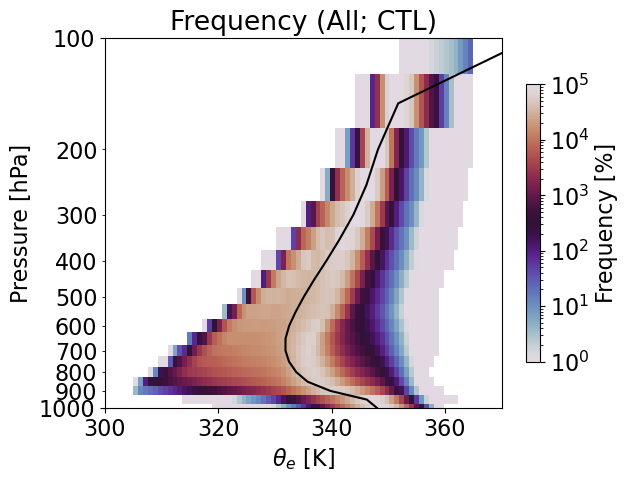

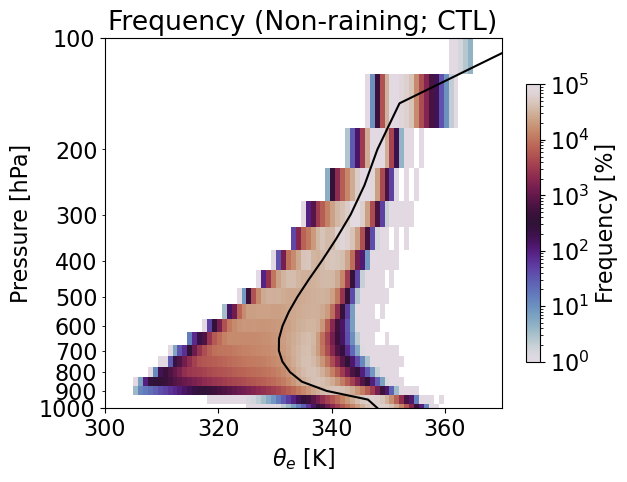

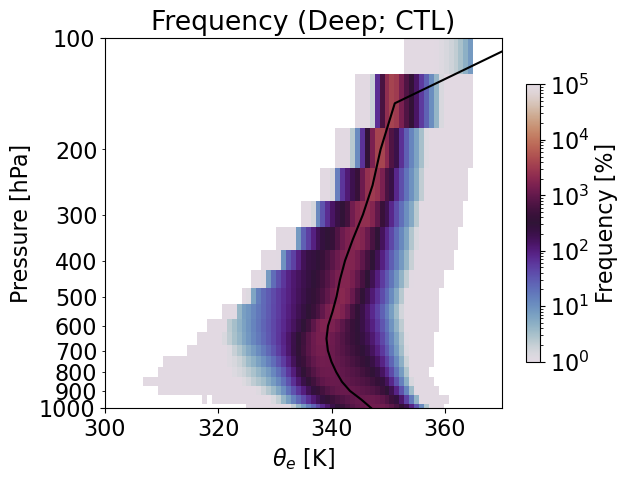

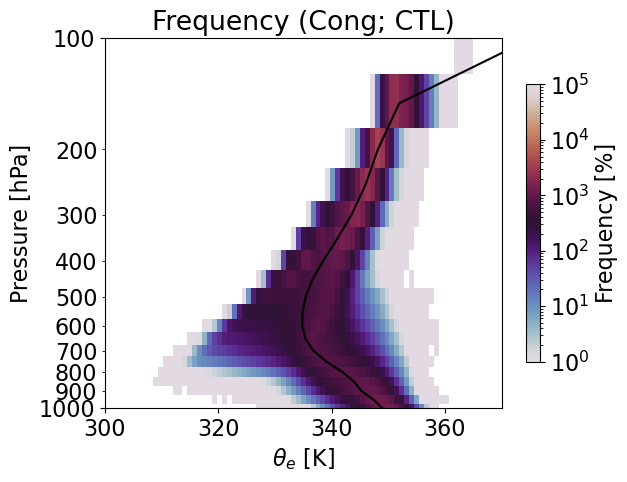

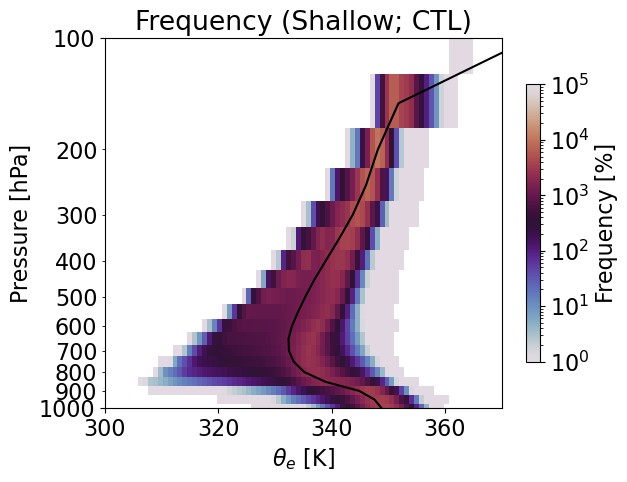

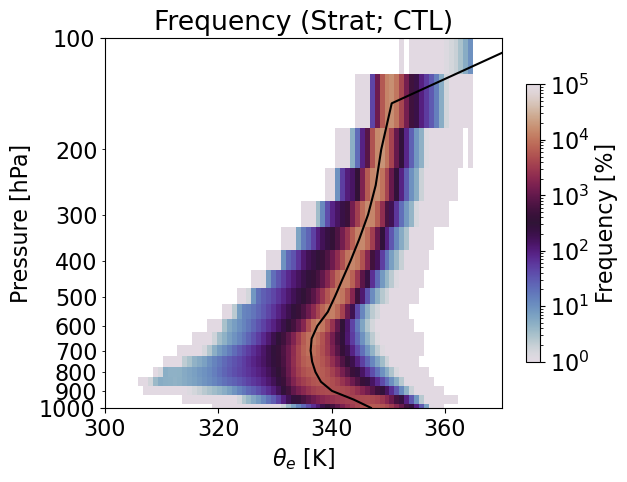

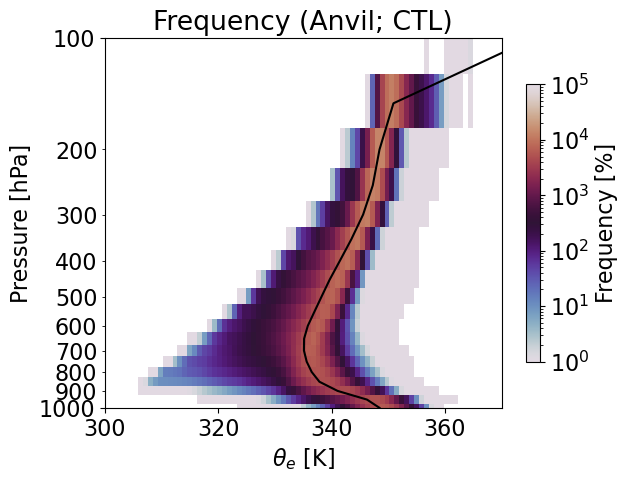

In [23]:
# Get variables

if not do_tests:

    ktest=0

    str_name='theta_e_mn'
    th_mean = get_var(allvars[ktest], str_name)
    str_name='frequency'
    frequency = get_var(allvars[ktest], str_name)
    str_name='qv'
    qv = get_var(allvars[ktest], str_name)
    str_name='tmpk'
    tmpk = get_var(allvars[ktest], str_name)
    str_name='w'
    w = get_var(allvars[ktest], str_name)
    str_name='rho'
    rho = get_var(allvars[ktest], str_name)
    vmf = w*rho # kg/m2/s
    str_name='lw'
    lw = get_var(allvars[ktest], str_name)
    str_name='lwc'
    lwc = get_var(allvars[ktest], str_name)
    lwcrf = (lw - lwc)*3600*24 # K/s --> K/d
    str_name='sw'
    sw = get_var(allvars[ktest], str_name)
    str_name='swc'
    swc = get_var(allvars[ktest], str_name)
    swcrf = (sw - swc)*3600*24 # K/s --> K/d

    # print(frequency.shape)
    frequency = np.mean(frequency,axis=(0,2))
    th_mean = np.mean(th_mean,axis=(0,2))
    qv_mean = np.mean(qv,axis=(0,2))
    tmpk_mean = np.mean(tmpk,axis=(0,2))
    vmf_mean = np.mean(vmf,axis=(0,2))
    # relh = get_rh(qv_mean, pres, tmpk_mean)
    relh = calc_relh(qv_mean, pres[np.newaxis,:,np.newaxis]*1e2, tmpk_mean, ice=True)
    lwcrf_mean = np.mean(lwcrf,axis=(0,2))
    swcrf_mean = np.mean(swcrf,axis=(0,2))

    plot_binned_frequency(bins, pres, frequency, th_mean, pclass_title, tests[ktest])
    # plot_binned_freqdiff(bins, pres, frequency, th_mean, pclass_title, tests[ktest])

    # Relative humidity
    # print()
    # print("Relative Hum")
    # plot_binned_var(bins, pres, relh, th_mean, 'RELH', '%', pclass_title, tests[ktest],
    #                 cmap='BrBG')

    # VMF
    # normmin=-1e0; normmax=1e0
    # norm = colors.SymLogNorm(linthresh=1e-2, linscale=1, vmin=normmin, vmax=normmax)
    # print()
    # print("VMF")
    # plot_binned_var(bins, pres, vmf_mean, th_mean, 'VMF', 'kg/m$^2$/s', pclass_title, tests[ktest],
    #                 cmap='RdGy_r', norm=norm)

    # # Longwave CRF
    # norm = colors.TwoSlopeNorm(vmin=-6, vcenter=0, vmax=8)
    # print()
    # print("Longwave CRF")
    # plot_binned_var(bins, pres, lwcrf_mean, th_mean, 'LW-CRF', 'K/d', pclass_title, tests[ktest],
    #                 cmap='RdBu_r', norm=norm)
    # norm = colors.TwoSlopeNorm(vmin=-2, vcenter=0, vmax=4)

    # # Shortwave CRF
    # print()
    # print("Shortwave CRF")
    # plot_binned_var(bins, pres, swcrf_mean, th_mean, 'SW-CRF', 'K/d', pclass_title, tests[ktest],
    #                 cmap='RdBu_r', norm=norm)

---
### Test differences

In [55]:
# Get variables

if do_tests:

    # ivar_select_x='strat'
    # ivar_select_y='deepc'
    ivar_select_x='vmfu'
    ivar_select_y='vmfd'

    binned_vars_all = {}
    
    pclass_area_tests=[]
    for ktest in range(ntest):

        str_name='pclass_area'
        pclass_area = (get_var(allvars[ktest], str_name))
        pclass_area_tests.append(pclass_area)
        str_name='pw'
        pw = (get_var(allvars[ktest], str_name))
        str_name='pw_sat'
        pw_sat = (get_var(allvars[ktest], str_name))
        satfrac = 1e2*pw / pw_sat
        str_name='rain'
        rain = (get_var(allvars[ktest], str_name))/24 # mm/d --> mm/hr
        str_name='vmfu'
        vmfu = (get_var(allvars[ktest], str_name))
        str_name='vmfd'
        vmfd = (get_var(allvars[ktest], str_name))
        vmfu = np.ma.masked_where(vmfu > 1e10, vmfu, copy=False)
        vmfd = np.ma.masked_where(vmfd > 1e10, vmfd, copy=False)
        str_name='lwacre'
        lwacre = (get_var(allvars[ktest], str_name))
        str_name='swacre'
        swacre = (get_var(allvars[ktest], str_name))

        ivar_x, bins_x, bin_axis_x, xlabel, log_x = binvar_settings(ivar_select_x, pw, satfrac, rain, lwacre, pclass_area, vmfu, vmfd)
        ivar_y, bins_y, bin_axis_y, ylabel, log_y = binvar_settings(ivar_select_y, pw, satfrac, rain, lwacre, pclass_area, vmfu, vmfd)

        ibinned_vars = run_dual_binning(bins_x, bins_y, ivar_x, ivar_y, pclass_area, pw, satfrac, lwacre, swacre, rain, vmfu, vmfd)
        binned_vars_all[tests[ktest]] = ibinned_vars


    # plot_binned_freq_diff(bins_x, bins_y, binned_vars['bin_freq'], binned_vars['bin_dxdt'], binned_vars['bin_dydt'],
    #                 ivar_select_x, ivar_select_y, tests[ktest], xlabel, ylabel, log_x, log_y, doaxline=True,
    #                 vec_scale=100)
    # plot_pclass_area(bins_x, bins_y, binned_vars['pclass_binned'], pclass_names, ivar_select_x, ivar_select_y,
    #                 tests[ktest], xlabel, ylabel, log_x, log_y, doaxline=True)
    # plot_binned_var(bins_x, bins_y, binned_vars['rain_binned'], 'Rain', 'mm/hr',
    #                 ivar_select_x, ivar_select_y, tests[ktest], xlabel, ylabel, log_x, log_y, doaxline=True,
    #                 norm=colors.LogNorm(vmin=5e-1, vmax=1e1))
    # plot_binned_var(bins_x, bins_y, binned_vars['satfrac_binned'], 'satfrac', '%',
    #                 ivar_select_x, ivar_select_y, tests[ktest], xlabel, ylabel, log_x, log_y, doaxline=True)

In [56]:
def plot_binned_freq_diff(bins_x, bins_y, bin_freq, bin_dxdt, bin_dydt, binvartag_x, binvartag_y,
                     test_str, xlabel, ylabel, log_x, log_y, doaxline=False, vec_scale=20):
        fig_title = test_str.upper()
        # create figure
        fig = plt.figure()#figsize=(14,4))
        ax = fig.add_subplot(111)
        ax.set_title(fig_title)
        ax.set_xlabel(xlabel)
        ax.set_ylabel(ylabel)
        ax.set_xscale(log_x)
        ax.set_yscale(log_y)
        # normmin=1e-3
        # normmax=1e1
        # norm=colors.LogNorm(vmin=normmin, vmax=normmax)
        norm=colors.SymLogNorm(linthresh=1, linscale=1, vmin=-1e3, vmax=1e3)
        im = ax.pcolormesh(bins_x, bins_y, np.transpose(bin_freq), cmap='RdBu_r', norm=norm)
        plt.xlim(np.min(bins_x), np.max(bins_x))
        plt.ylim(np.min(bins_y), np.max(bins_y))
        if doaxline:
                plt.axline((bins_x[0],bins_y[0]), (bins_x.max(),bins_y.max()), color='k', lw=1)
        cbar = plt.colorbar(im, ax=ax, shrink=0.75)
        cbar.ax.set_ylabel('Frequency diff. [%]')
        # trend vectors
        # plot_trend_vectors(ax, bins_x, bins_y, bin_dxdt, bin_dydt, skip=2, normalize=False, vec_scale=vec_scale)
        # plt.savefig(figdir+'pclass_frac_'+binvartag+'_'+test_str+'.png',dpi=200, facecolor='white', \
        #             bbox_inches='tight', pad_inches=0.2)
        plt.show()
        plt.close()

ncrf36h


/tmp/ipykernel_44040/3414618876.py:8: RuntimeWarning: divide by zero encountered in divide
  pclass_binned = 1e2*(binned_vars_all[tests[ktest2]]['pclass_binned'] - binned_vars_all[tests[ktest1]]['pclass_binned']) / binned_vars_all[tests[ktest1]]['pclass_binned']
/tmp/ipykernel_44040/3414618876.py:8: RuntimeWarning: invalid value encountered in divide
  pclass_binned = 1e2*(binned_vars_all[tests[ktest2]]['pclass_binned'] - binned_vars_all[tests[ktest1]]['pclass_binned']) / binned_vars_all[tests[ktest1]]['pclass_binned']
/tmp/ipykernel_44040/3414618876.py:32: RuntimeWarning: divide by zero encountered in divide
  bin_freq = 1e2*((bin_freq2/total2) - (bin_freq1/total1)) / (bin_freq1/total1)
/tmp/ipykernel_44040/3414618876.py:32: RuntimeWarning: invalid value encountered in divide
  bin_freq = 1e2*((bin_freq2/total2) - (bin_freq1/total1)) / (bin_freq1/total1)


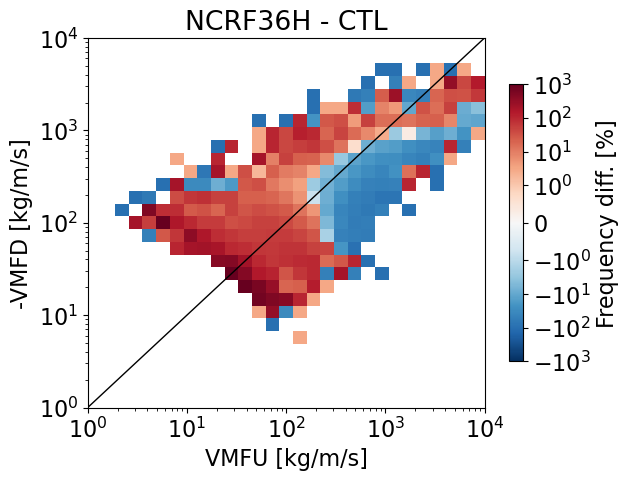

STRATANVIL_OFF


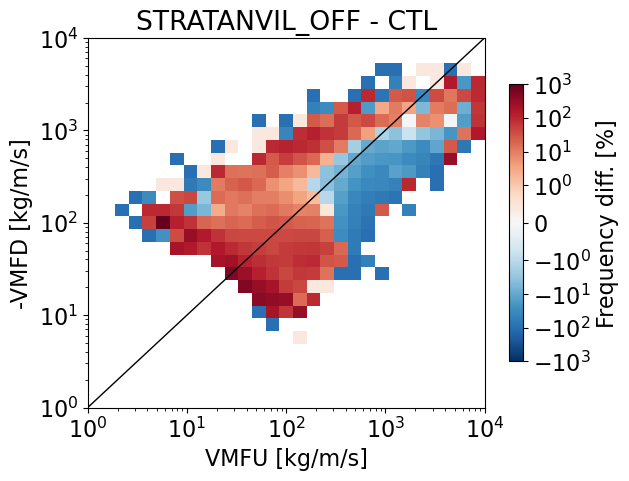

STRAT_OFF


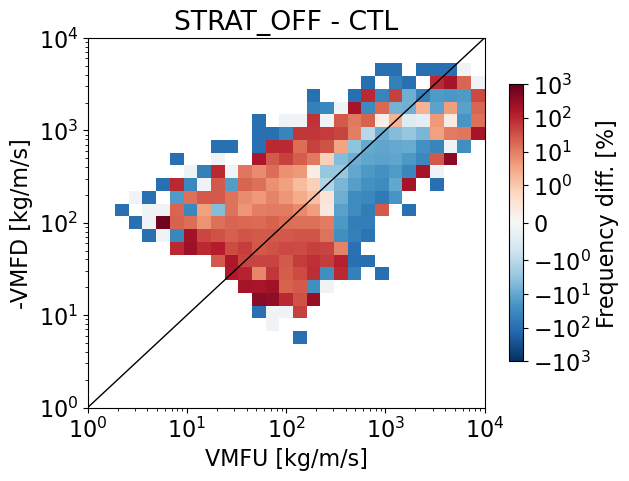

STRATANVIL_ON


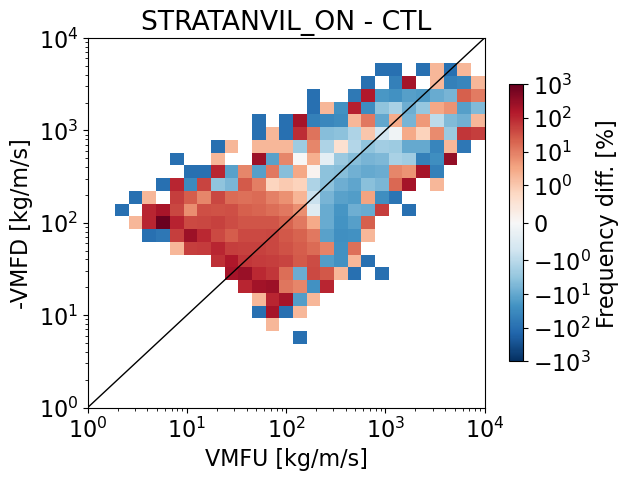

In [58]:
for ktest in range(1,ntest):

    ktest1=0
    ktest2=ktest
    test_str=tests[ktest2]+' - '+tests[ktest1]
    print(tests[ktest2])

    pclass_binned = 1e2*(binned_vars_all[tests[ktest2]]['pclass_binned'] - binned_vars_all[tests[ktest1]]['pclass_binned']) / binned_vars_all[tests[ktest1]]['pclass_binned']

    pclass_binned1 = binned_vars_all[tests[ktest1]]['pclass_binned']
    pclass_binned2 = binned_vars_all[tests[ktest2]]['pclass_binned']

    # plot_pclass_area_diff(bins_x, bins_y, pclass_binned, pclass_names, ivar_select_x, ivar_select_y,
    #                 test_str, xlabel, ylabel, log_x, log_y, doaxline=True)

    # pvar_str = 'bin_freq'
    # bin_freq1 = binned_vars_all[tests[ktest1]]['bin_freq']
    # bin_freq2 = binned_vars_all[tests[ktest2]]['bin_freq']

    # mean=[]
    # # for kclass in range(1,6):
    # for kclass in range(4,5):
    #     imean = (np.nansum( pclass_binned2[:,:,kclass]*bin_freq2 ) / np.sum(bin_freq2)) - \
    #             (np.nansum( pclass_binned1[:,:,kclass]*bin_freq1 ) / np.sum(bin_freq1))
    #     mean.append(imean)
    #     print(imean)

    bin_freq1 = binned_vars_all[tests[ktest1]]['bin_freq']
    total1 = np.nansum(bin_freq1)
    bin_freq2 = binned_vars_all[tests[ktest2]]['bin_freq']
    total2 = np.nansum(bin_freq2)
    bin_freq = 1e2*((bin_freq2/total2) - (bin_freq1/total1)) / (bin_freq1/total1)
    # bin_freq = 1e2*((bin_freq2) - (bin_freq1))

    bin_dxdt1 = binned_vars_all[tests[ktest1]]['bin_dxdt']
    bin_dxdt2 = binned_vars_all[tests[ktest2]]['bin_dxdt']
    bin_dxdt = 1e2*(bin_dxdt2 - bin_dxdt1) / bin_dxdt1

    bin_dydt1 = binned_vars_all[tests[ktest1]]['bin_dydt']
    bin_dydt2 = binned_vars_all[tests[ktest2]]['bin_dydt']
    bin_dydt = 1e2*(bin_dydt2 - bin_dydt1) / bin_dydt1

    plot_binned_freq_diff(bins_x, bins_y, bin_freq, bin_dxdt, bin_dydt,
                    ivar_select_x, ivar_select_y, test_str, xlabel, ylabel, log_x, log_y, doaxline=True,
                    vec_scale=400)
    # if ktest == 1:
    #     plot_binned_freq_v2(bins_x, bins_y, bin_freq1, bin_dxdt1, bin_dydt1,
    #                 ivar_select_x, ivar_select_y, tests[ktest1], xlabel, ylabel, log_x, log_y, doaxline=True,
    #                 vec_scale=100)
    # plot_binned_freq_v2(bins_x, bins_y, bin_freq2, bin_dxdt2, bin_dydt2,
    #                 ivar_select_x, ivar_select_y, tests[ktest2], xlabel, ylabel, log_x, log_y, doaxline=True,
    #                 vec_scale=100)

In [54]:
for kclass in range(6):
    print()
    imean = np.nanmean(pclass_area_tests[1][:,:,kclass,:,:]) - np.nanmean(pclass_area_tests[0][:,:,kclass,:,:])
    print(imean)
    imean = 1e2*(np.nanmean(pclass_area_tests[1][:,:,kclass,:,:]) - np.nanmean(pclass_area_tests[0][:,:,kclass,:,:])) / np.nanmean(pclass_area_tests[0][:,:,kclass,:,:])
    print(imean)


3.3597717
5.136213963739103

-0.31269658
-16.36938794919434

-0.07182062
-4.746945026992525

-0.29514384
-7.625542845526953

-1.9011769
-23.177208648282893

-0.7789545
-12.561237132522418


---
### One-dimensional binned plots

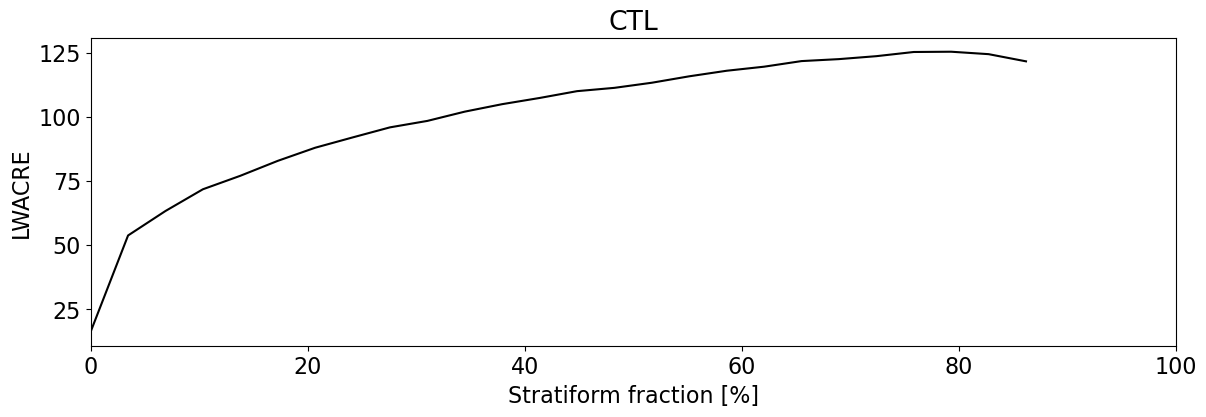

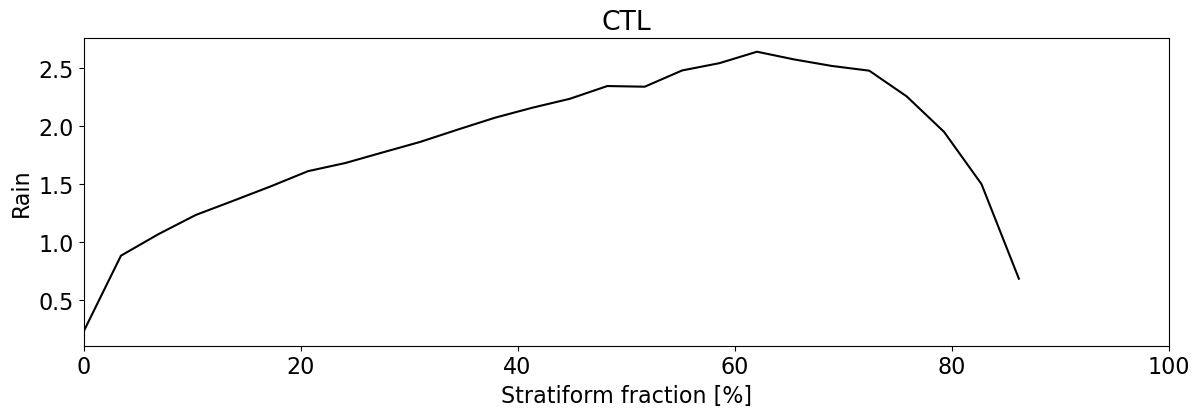

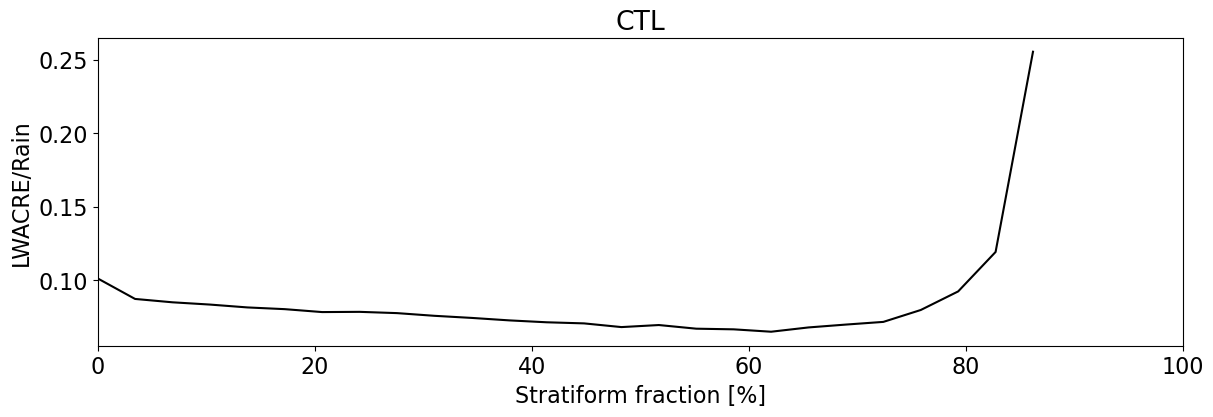


NEW BIN VARIABLES
NEW BIN VARIABLES
NEW BIN VARIABLES



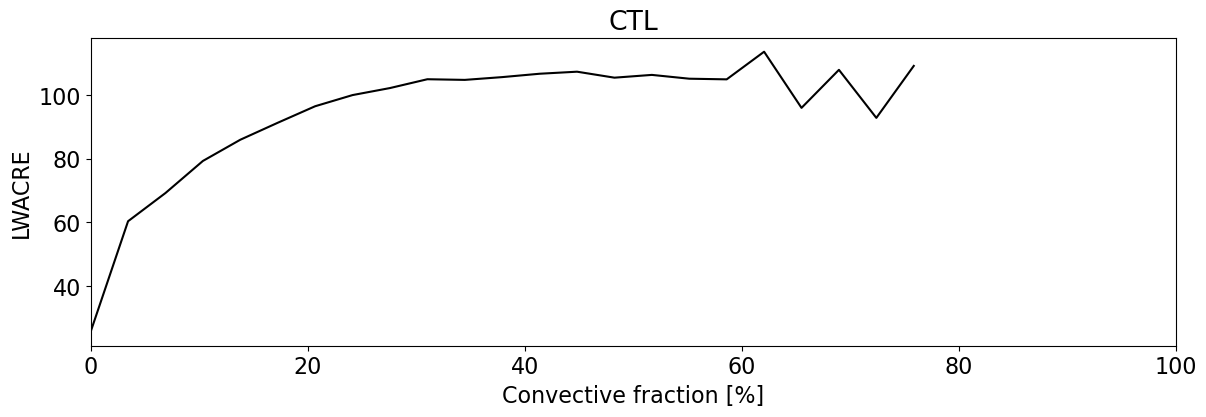

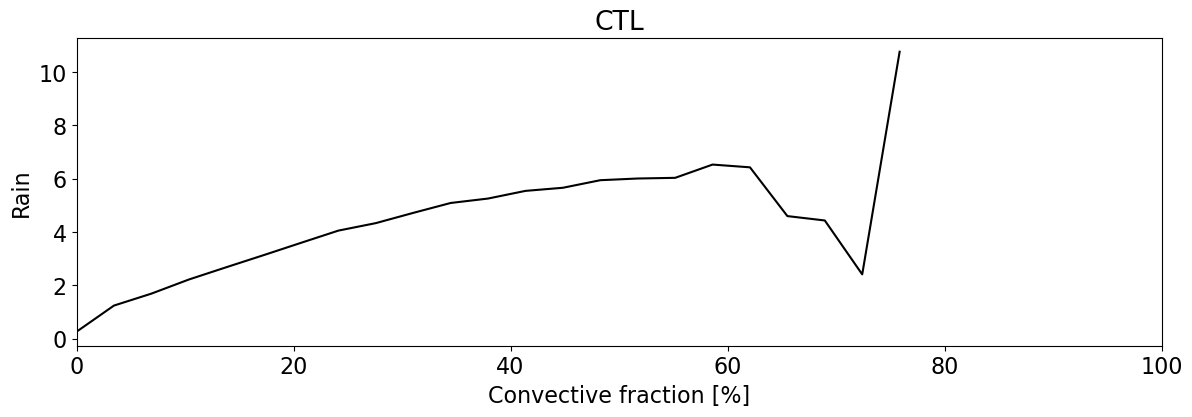

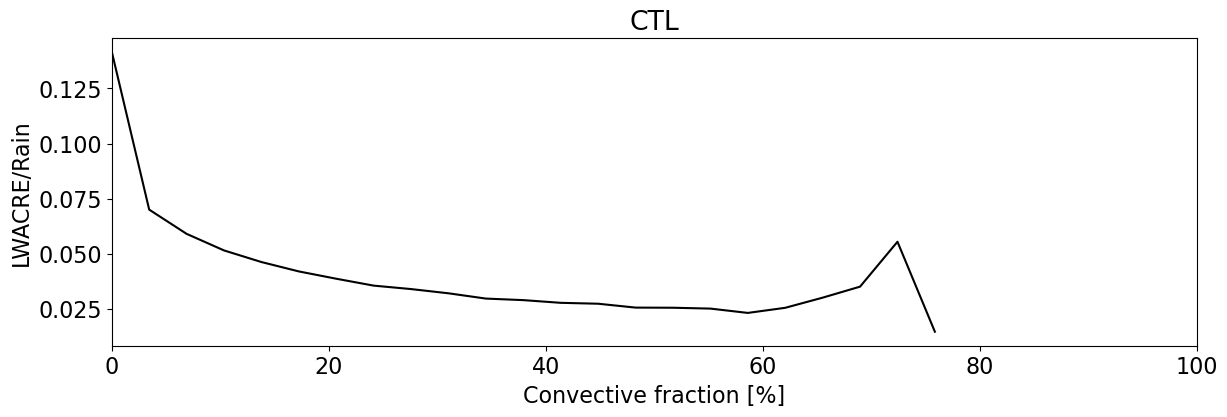

In [19]:
ivar_select_x='strat'
ivar_x, bins_x, bin_axis_x, xlabel, log_x = binvar_settings(ivar_select_x, pw, satfrac, rain, lwacre, pclass_area)
binned_vars = run_binning(pclass_area, bins_x, ivar_x, pw, satfrac, lwacre, rain)

plot_binned_var_1d(bins_x, binned_vars['lwacre_binned'], xlabel, 'LWACRE', log_x, 'linear')
plot_binned_var_1d(bins_x, binned_vars['rain_binned'], xlabel, 'Rain', log_x, 'linear')
lv0=2.5e6 # J/kg
lw_fdbck = binned_vars['lwacre_binned'] / (binned_vars['rain_binned']*lv0/(3600))
plot_binned_var_1d(bins_x, lw_fdbck, xlabel, 'LWACRE/Rain', log_x, 'linear')

print()
print("NEW BIN VARIABLES")
print("NEW BIN VARIABLES")
print("NEW BIN VARIABLES")
print()

ivar_select_x='deepc'
ivar_x, bins_x, bin_axis_x, xlabel, log_x = binvar_settings(ivar_select_x, pw, satfrac, rain, lwacre, pclass_area)
binned_vars = run_binning(pclass_area, bins_x, ivar_x, pw, satfrac, lwacre, rain)

plot_binned_var_1d(bins_x, binned_vars['lwacre_binned'], xlabel, 'LWACRE', log_x, 'linear')
plot_binned_var_1d(bins_x, binned_vars['rain_binned'], xlabel, 'Rain', log_x, 'linear')
lv0=2.5e6 # J/kg
lw_fdbck = binned_vars['lwacre_binned'] / (binned_vars['rain_binned']*lv0/(3600))
plot_binned_var_1d(bins_x, lw_fdbck, xlabel, 'LWACRE/Rain', log_x, 'linear')